# LSTM 일봉 주가 예측하기

In [141]:
# 참고source code: https://github.com/minji-OH/Analysis_in_Python/blob/master/Comparing%20GRU%20and%20LSTM%20with%20Stock%20data.ipynb

# 대금 / 시총 비율 을 이용
# Bidirectional LSTM 이용
# 
# FOR_PERIODS 마지막날 종가 대비 3일 후의 최고 상승률을 단일output 으로 놓고 예측(Dense(units=1))
# sqlite DB 이용

import sys
print(sys.executable)

# numpy 설치했음에도 에러가 날때
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\lib\\site-packages')
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow')
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\lib')       
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\DLLs')        
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\python37.zip')


import numpy as np
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import SGD, Adam




C:\Users\ample\miniconda3\python.exe


In [142]:
import sqlite3

conn = sqlite3.connect("D:\\Dev\\CSharp\\DBmakerForDeeplearn\\DBmakerForDeeplearn\\bin\\Debug\\DB\\GijoonForKeras.db")
cur = conn.cursor()

cur.execute("SELECT * FROM gijoon") 
             
rows = cur.fetchall()

df = pd.DataFrame(rows, columns=['id', 'code', 'name', 'date', 'endprice', 'updown', 'compare', 'volume', 'totalmoney', 'startprice', 'highprice', 'lowprice', 'mkcap', 'shares', 'ratio_start', 'ratio_high', 'ratio_low', 'ratio_end', 'ratio_nday', 'totalmoney_mkcap'])

print(df.shape)
   
conn.close()


(38397, 20)


In [143]:
all_data = df[['id', 'ratio_end', 'totalmoney_mkcap']]

y_tr_all = df[['id', 'ratio_nday']]

FEATURES = all_data.shape[1] - 1 # id 열 제외할거기 때문에 1 빼줌
TIME_STEPS = 7
FOR_PERIODS = 1

all_data.head(15)




,id,ratio_end,totalmoney_mkcap
0,0,-1.48,0.003
1,0,-4.05,0.006
2,0,0.31,0.002
3,0,-3.43,0.005
4,0,5.97,0.006
5,0,0.61,0.006
6,0,-3.93,0.004
7,0,1.89,0.003
8,0,1.08,0.002
9,0,-2.60,0.002


In [144]:
y_tr_all.head(15)

,id,ratio_nday
0,0,-0.90
1,0,1.25
2,0,3.58
3,0,9.52
4,0,3.35
5,0,2.12
6,0,6.30
7,0,2.94
8,0,26.61
9,0,64.05


In [145]:

# 스케일러 하나 만들어두고 전 데이터 fit
sc = MinMaxScaler(feature_range=(0,1))
sc_ratio_nday = MinMaxScaler(feature_range=(0,1))


def ScaleWithoutIdAndConcatAgain(all_data_, scaler):
    # id열 뗀 나머지 스케일 하고 다시 id 붙이기
    for_scale = all_data_.iloc[:,1:]

    #TODO: 검사할때 스케일 끄고하기
    scaled = scaler.fit_transform(for_scale)  # 전 데이터로 fit
    #scaled = for_scale # TODO: 

    id = all_data.iloc[:,0]
    scaled = pd.DataFrame(scaled)
    all_scaled = pd.concat([id,scaled],axis=1)
    return all_scaled


y_tr_all_scaled = ScaleWithoutIdAndConcatAgain(y_tr_all, sc_ratio_nday)
print(y_tr_all_scaled[0:5])
print(y_tr_all_scaled.shape)


def GetScaledYTrainById(index): # 3일간 최고상승률 가져오기
    ythis = y_tr_all_scaled[y_tr_all_scaled['id'] == index].iloc[:,1:]
    #print(ythis.shape)
    ythis = ythis[TIME_STEPS-1:].reset_index(drop=True)  # 인덱스 리셋
    
    nparray = ythis.values
    nparray = nparray.reshape(ythis.shape[0], 1, ythis.shape[1])
    return nparray
    
    
def GetOrigYTrainById(index): # 3일간 최고상승률 가져오기
    ythis = y_tr_all[y_tr_all['id'] == index].iloc[:,1:]
    #print(ythis.shape)
    ythis = ythis[TIME_STEPS-1:].reset_index(drop=True)  # 인덱스 리셋
    nparray = ythis.values
    nparray = nparray.reshape(ythis.shape[0], 1, ythis.shape[1])
    return nparray    

    

   id         0
0   0  0.448896
1   0  0.465852
2   0  0.484227
3   0  0.531073
4   0  0.482413
(38397, 2)


(38397, 3)
<class 'pandas.core.frame.DataFrame'>
   id         0         1
0   0  0.475333  0.000593
1   0  0.432500  0.001187
2   0  0.505167  0.000396
3   0  0.442833  0.000989
4   0  0.599500  0.001187


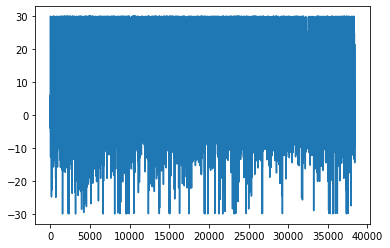

In [146]:

all_data['ratio_end'].plot()

print(all_data.shape)
print(type(all_data)) # 'pandas.core.frame.DataFrame'

all_scaled = ScaleWithoutIdAndConcatAgain(all_data, sc)

print(all_scaled[0:5])



In [155]:
def Make_LSTM_model():
    # create a model. LSTM architecture
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (TIME_STEPS, FEATURES),  
                           activation = 'tanh')))
    #model.add(Dropout(0.1))
    model.add(LSTM(units = 50, activation = 'tanh'))
    model.add(Dense(units=1))
    
    #adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #sgd = SGD(lr = 0.01, decay = 1e-7, momentum = 0.9, nesterov = False)
    
    model.compile(optimizer = Adam(),
                         loss = 'mean_squared_error')
    return model 

my_LSTM_model = Make_LSTM_model()

In [156]:
def InspectData(index):
    print('----데이터 비교(맨 윗쪽에서 scale 끄고하기)---')
    part = GetScaledDataByIndex(index)
    print(part.shape)
    print(part[part.shape[0]-5:])
    print('-------')
    xtrain = PrepareData(part, TIME_STEPS, FOR_PERIODS)
    print(str(i) + ': ' + ", ".join(map(str, xtrain.shape)))
    print(xtrain[xtrain.shape[0]-5:])
    
    y_train = GetYTrainById(index)
    print(y_train[y_train.shape[0]-5:])
    
    print('----InspectData(종료)---')

In [157]:

# 모듈로 구분하기, scale / train 
# 학습, 테스트 데이터 구분하기

# 부분 시퀀스로 나눔
def PrepareData(data, time_steps, for_periods):
    # 몇종목은 학습 데이터로, 나머지 종목은 테스트 데이터로
    
    dataLen = len(data)
    X_train = [] 
    for i in range(time_steps, dataLen+1):  # 종가를 타임스텝5로 잘라 배열하는듯. range(n, m) n 부터 m까지
        X_train.append(data[i-time_steps:i]) # 종가 5개
    X_train = np.array(X_train)
    return X_train

In [177]:

def MakeDataAndFitModel(index, jongData):

    X_train = PrepareData(jongData, TIME_STEPS, FOR_PERIODS)
    print(X_train.shape) # (47, 7, 2)  (행길이, 시퀀스길이, 피쳐)
    
    y_train = GetScaledYTrainById(index)
    print(y_train.shape) # (47, 1, 1)  (행길이, 시퀀스길이, 피쳐)
    
    my_LSTM_model.fit(X_train, y_train, epochs = 10, batch_size = 30, verbose = 1) # 한 종목 에포크를 너무 많이돌리면 과대적합. 10번정도 대충.
    return X_train
    
def GetScaledDataByIndex(index):
    return all_scaled[all_scaled['id'] == index].iloc[:,1:]

def GetOrigDataByIndex(index):
    return all_data[all_data['id'] == index].iloc[:,1:]

    

In [178]:
for i in range(100):  # range(n) [0...n-1]
    part = GetScaledDataByIndex(i)
    
    xtrain = MakeDataAndFitModel(i, part)
    print('*******')
    #InspectData(i)
    
    

(45, 7, 2)
(45, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0135
Epoch 2/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 3/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 4/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0127
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 9/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0126
*******
(42, 7, 2)
(42, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0077
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 3/10
2/2 [===

2/2 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 5/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 6/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 10/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0042
*******
(40, 7, 2)
(40, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 5/10
2/2 [==============================] - 0s

2/2 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 8/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 9/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 10/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0125
*******
(44, 7, 2)
(44, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 3/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0065
Epoch 7/10
2/2 [==============================] - 0

2/2 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 10/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0042
*******
(46, 7, 2)
(46, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0045
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 10/10
2/2 [==============================] - 

2/2 [==============================] - 0s 8ms/step - loss: 0.0054
*******
(48, 7, 2)
(48, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0061
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 5/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 6/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 8/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 9/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 10/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0056
*******
(38, 7, 2)
(38, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 2/10
2/2 [======

2/2 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0108
Epoch 6/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0108
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0109
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 10/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0108
*******
(45, 7, 2)
(45, 1, 1)
Epoch 1/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0102
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0102
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 4/10
2/2 [==============================] - 0

In [180]:

INDEX_OF_TEST = 1
NUM_OF_PRINT = 20

data = GetDataByIndex(INDEX_OF_TEST)
orig = GetOrigDataByIndex(INDEX_OF_TEST)
orig_separated = PrepareData(orig, TIME_STEPS, FOR_PERIODS)

X_test = PrepareData(data, TIME_STEPS, FOR_PERIODS)

print(orig_separated[0:NUM_OF_PRINT])
print("------")

origY = GetOrigYTrainById(INDEX_OF_TEST)
print(origY[0:NUM_OF_PRINT])

    
pred = my_LSTM_model.predict(X_test)
    
pred = sc_ratio_nday.inverse_transform(pred)
print('------inverse_transformed-----')

print('LSTM_prediction: ' + ", ".join(map(str,pred.shape)))

np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.2f}".format(x)})
result = np.round(pred, 2)
result = result[0:NUM_OF_PRINT]
for data in result:
    print(data)
    #print("{0:0.2f}".format(cell))


[[[-7.69 0.72]
  [3.83 0.18]
  [-1.44 0.14]
  [8.31 0.18]
  [16.09 0.83]
  [-2.98 0.17]
  [0.00 0.27]]

 [[3.83 0.18]
  [-1.44 0.14]
  [8.31 0.18]
  [16.09 0.83]
  [-2.98 0.17]
  [0.00 0.27]
  [2.14 0.11]]

 [[-1.44 0.14]
  [8.31 0.18]
  [16.09 0.83]
  [-2.98 0.17]
  [0.00 0.27]
  [2.14 0.11]
  [-1.18 0.17]]

 [[8.31 0.18]
  [16.09 0.83]
  [-2.98 0.17]
  [0.00 0.27]
  [2.14 0.11]
  [-1.18 0.17]
  [-1.32 0.06]]

 [[16.09 0.83]
  [-2.98 0.17]
  [0.00 0.27]
  [2.14 0.11]
  [-1.18 0.17]
  [-1.32 0.06]
  [7.51 0.85]]

 [[-2.98 0.17]
  [0.00 0.27]
  [2.14 0.11]
  [-1.18 0.17]
  [-1.32 0.06]
  [7.51 0.85]
  [2.00 0.61]]

 [[0.00 0.27]
  [2.14 0.11]
  [-1.18 0.17]
  [-1.32 0.06]
  [7.51 0.85]
  [2.00 0.61]
  [4.89 0.32]]

 [[2.14 0.11]
  [-1.18 0.17]
  [-1.32 0.06]
  [7.51 0.85]
  [2.00 0.61]
  [4.89 0.32]
  [0.00 0.17]]

 [[-1.18 0.17]
  [-1.32 0.06]
  [7.51 0.85]
  [2.00 0.61]
  [4.89 0.32]
  [0.00 0.17]
  [14.92 0.47]]

 [[-1.32 0.06]
  [7.51 0.85]
  [2.00 0.61]
  [4.89 0.32]
  [0.00 0.17]


In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [12]:
confirm_result(y_test, y_pred)

,Results
MAE,39.01289
RMSE,48.22952
RMSLE,0.02685
R2,0.77401
